In [24]:

from IPython.display import display, Markdown
import warnings
warnings.filterwarnings("ignore")

def title(text):
    display(Markdown(f"## {text}"))

def subtitle(text):
    display(Markdown(f"### {text}"))



title("Deceptive Review Detection using Semi-Supervised Learning ")
subtitle("Dataset: Deceptive Opinion Spam Corpus v1.4")


## Deceptive Review Detection using Semi-Supervised Learning 

### Dataset: Deceptive Opinion Spam Corpus v1.4

In [9]:
import zipfile
import os

zip_path = "/content/op_spam_v1.4.zip"

extract_dir = "/content/op_spam_v1"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Files extracted to: {extract_dir}")


Files extracted to: /content/op_spam_v1


In [3]:
import os
import pandas as pd

def load_op_spam_labels_only(root_dir, output_csv="op_spam_labeled.csv"):
    data = []

    for polarity in ['negative_polarity', 'positive_polarity']:
        polarity_path = os.path.join(root_dir, polarity)

        for truth_source in os.listdir(polarity_path):
            full_path = os.path.join(polarity_path, truth_source)
            label = 0 if "deceptive" in truth_source else 1

            for fold in os.listdir(full_path):
                fold_path = os.path.join(full_path, fold)
                for fname in os.listdir(fold_path):
                    file_path = os.path.join(fold_path, fname)
                    with open(file_path, "r", encoding="utf-8") as f:
                        review = f.read().strip()
                        data.append({
                            "text": review,
                            "label": label
                        })

    df = pd.DataFrame(data)
    df.to_csv(output_csv, index=False)
    print(f" Dataset saved to {output_csv} with {len(df)} samples.")
    return df



df = load_op_spam_labels_only("/content/op_spam_v1/op_spam_v1.4")

✅ Dataset saved to op_spam_labeled.csv with 1600 samples.


In [25]:

import pandas as pd


display(df.sample(5))
display(df['label'].value_counts().rename({0: 'Deceptive', 1: 'Truthful'}).to_frame(name='Count'))


,text,label
325,Problems started when I booked the InterContin...,0
837,I stayed at the Talbott twice in the last few ...,1
1296,We stayed at the beautiful Millennium Knickerb...,0
236,The staff at the James Chicago hotel seemed de...,0
1331,I really enjoyed staying at this hotel. The se...,0


,Count
label,
Deceptive,800
Truthful,800


In [26]:

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    stop_words='english',
    max_features=3000,
    ngram_range=(1, 2)
)

X = vectorizer.fit_transform(df['text'])
y = df['label'].values


print(f" Vectorized {X.shape[0]} samples with {X.shape[1]} features.")



 Vectorized 1600 samples with 3000 features.


In [29]:

from sklearn.model_selection import train_test_split
import numpy as np


X_labeled, X_unlabeled, y_labeled, y_unlabeled_true = train_test_split(
    X, y, test_size=0.9, stratify=y, random_state=42
)

y_unlabeled = [-1] * len(y_unlabeled_true)

bullet(f"Labeled : {len(y_labeled)}")
bullet(f" Unlabeled : {len(y_unlabeled)}")


- Labeled : 160

-  Unlabeled : 1440

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np



In [31]:
base_model = LogisticRegression(max_iter=1000, solver='lbfgs')
base_model.fit(X_labeled, y_labeled)



LogisticRegression(max_iter=1000)

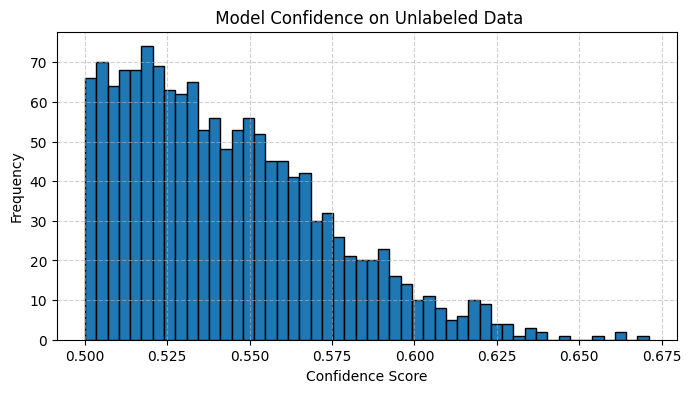

In [35]:


prob_preds = base_model.predict_proba(X_unlabeled)
confidence_scores = np.max(prob_preds, axis=1)
pseudo_labels = np.argmax(prob_preds, axis=1)


plt.figure(figsize=(8, 4))
plt.hist(confidence_scores, bins=50, color="#1f77b4", edgecolor='black')
plt.title(" Model Confidence on Unlabeled Data")
plt.xlabel("Confidence Score")
plt.ylabel("Frequency")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


In [36]:


THRESHOLD = 0.95

high_confidence_idx = np.where(confidence_scores >= THRESHOLD)[0]
X_pseudo = X_unlabeled[high_confidence_idx]
y_pseudo = pseudo_labels[high_confidence_idx]

bullet(f" Pseudo-labeled samples added: {len(y_pseudo)}")


-  Pseudo-labeled samples added: 0

In [38]:
!pip install nltk

In [41]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
import re

stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    words = text.split()
    words = [word for word in words if word not in stop_words]
    return " ".join(words)

df["clean_text"] = df["text"].apply(clean_text)


In [43]:
df["clean_text"]

,clean_text
0,staff talbott hotel completely unresponsive to...
1,recently stayed hard rock hotel chicago labor ...
2,experience ambassador east hotel truly terribl...
3,trip chicago complete delight despite stay aff...
4,affinia chicago obviously caters wedding guest...
...,...
1595,wife spent honeymoon chicago summer time staye...
1596,money amalfi hotel place way thread count egyp...
1597,glad decided stay intercontinental chicago fir...
1598,husband stay amalfi every year anniversary lov...


In [44]:
vectorizer = TfidfVectorizer(
    max_features=8000,
    ngram_range=(1, 3),
    sublinear_tf=True,
    stop_words='english'
)
X = vectorizer.fit_transform(df["clean_text"])


In [46]:
from xgboost import XGBClassifier

base_model = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss'
)
base_model.fit(X_labeled, y_labeled)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

In [48]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(base_model, X_labeled, y_labeled, cv=5, scoring='accuracy')
print(f"Base model accuracy: {scores.mean():.3f} ± {scores.std():.3f}")


Base model accuracy: 0.644 ± 0.076


In [49]:
import spacy
nlp = spacy.load("en_core_web_sm")

def spacy_preprocess(text):
    doc = nlp(text.lower())
    tokens = [token.lemma_ for token in doc
              if not token.is_stop and not token.is_punct and token.is_alpha]
    return " ".join(tokens)

df["clean_text"] = df["text"].apply(spacy_preprocess)


In [50]:
vectorizer = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 3),       # very powerful
    sublinear_tf=True,
    strip_accents='unicode',
    norm='l2',
    min_df=3,
    max_df=0.95
)
X = vectorizer.fit_transform(df["clean_text"])


In [62]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=500, random_state=42)
X_reduced = svd.fit_transform(X)


In [63]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_reduced,
    df["label"],
    test_size=0.2,
    random_state=42,
    stratify=df["label"]
)


In [64]:
from xgboost import XGBClassifier

model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    colsample_bytree=0.8,
    subsample=0.9,
    use_label_encoder=False,
    eval_metric='logloss'
)
model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

In [65]:
from sklearn.metrics import accuracy_score

y_pred = model.predict(X_val)
acc = accuracy_score(y_val, y_pred)

print(f" Validation Accuracy: {acc:.3f}")


 Validation Accuracy: 0.863


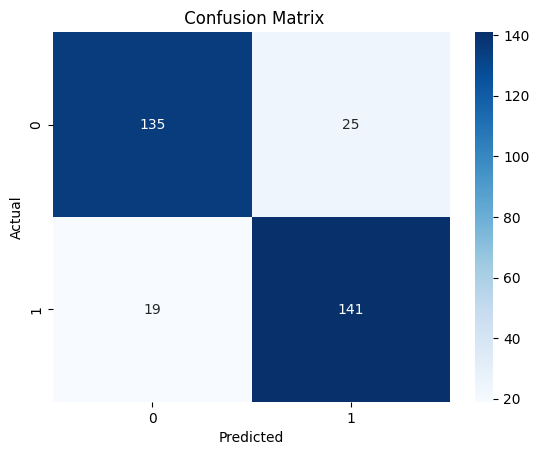

In [66]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title(" Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [67]:
print("Original label distribution:")
print(df["label"].value_counts(normalize=True))

print("\nTrain label distribution:")
print(pd.Series(y_train).value_counts(normalize=True))

print("\nValidation label distribution:")
print(pd.Series(y_val).value_counts(normalize=True))


Original label distribution:
label
0    0.5
1    0.5
Name: proportion, dtype: float64

Train label distribution:
label
0    0.5
1    0.5
Name: proportion, dtype: float64

Validation label distribution:
label
1    0.5
0    0.5
Name: proportion, dtype: float64


In [68]:
df["label"].head(10), y_train[:10]


(0    0
 1    0
 2    0
 3    0
 4    0
 5    0
 6    0
 7    0
 8    0
 9    0
 Name: label, dtype: int64,
 1332    0
 921     1
 1398    0
 1408    0
 976     1
 226     0
 551     1
 597     1
 692     1
 782     1
 Name: label, dtype: int64)

In [69]:
df["label"].value_counts()


,count
label,
0,800
1,800


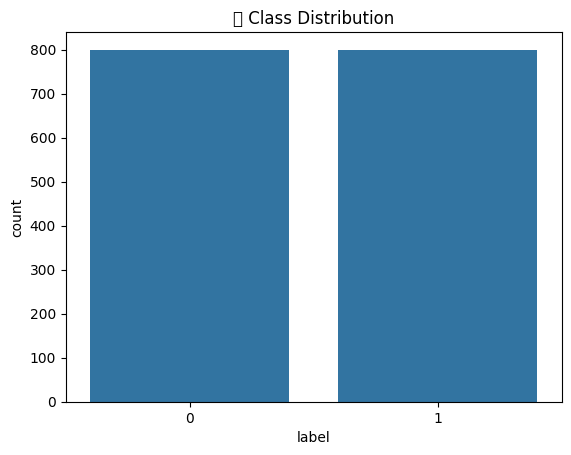

In [70]:
import seaborn as sns
sns.countplot(data=df, x="label")
plt.title("📊 Class Distribution")
plt.show()


In [71]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))


              precision    recall  f1-score   support

           0       0.88      0.84      0.86       160
           1       0.85      0.88      0.87       160

    accuracy                           0.86       320
   macro avg       0.86      0.86      0.86       320
weighted avg       0.86      0.86      0.86       320



In [72]:
prob_preds = base_model.predict_proba(X_unlabeled)

confidence_scores = np.max(prob_preds, axis=1)

pseudo_labels = np.argmax(prob_preds, axis=1)


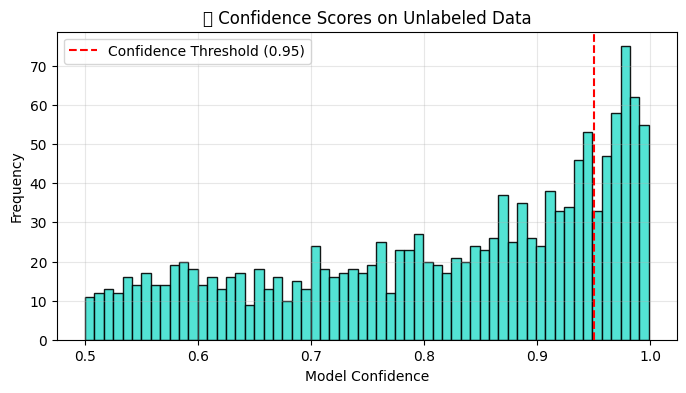

In [73]:
plt.figure(figsize=(8,4))
plt.hist(confidence_scores, bins=60, color="#40E0D0", edgecolor='black', alpha=0.9)
plt.axvline(0.95, color='red', linestyle='--', label='Confidence Threshold (0.95)')
plt.xlabel("Model Confidence")
plt.ylabel("Frequency")
plt.title("🔎 Confidence Scores on Unlabeled Data")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [74]:
THRESHOLD = 0.95
high_conf_idx = np.where(confidence_scores >= THRESHOLD)[0]

X_pseudo = X_unlabeled[high_conf_idx]
y_pseudo = pseudo_labels[high_conf_idx]

print(f"Pseudo-labeled (95% THRESHOLD ) samples: {len(y_pseudo)}")


Pseudo-labeled (95% THRESHOLD ) samples: 324


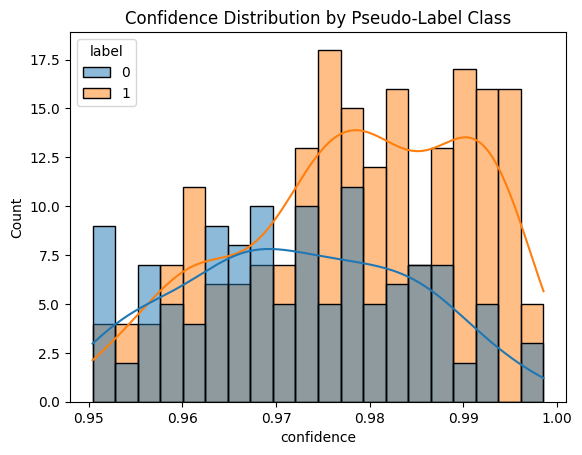

In [77]:
import pandas as pd
df_conf = pd.DataFrame({
    'confidence': confidence_scores[high_conf_idx],
    'label': y_pseudo
})

sns.histplot(data=df_conf, x='confidence', hue='label', bins=20, kde=True)
plt.title("Confidence Distribution by Pseudo-Label Class")
plt.show()


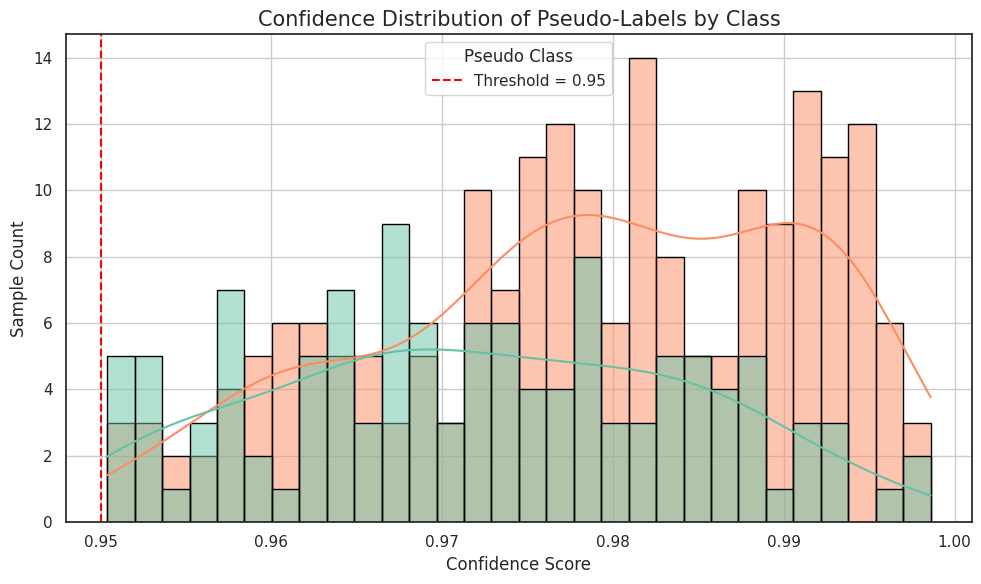

In [103]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

df_pseudo = pd.DataFrame({
    "confidence": confidence_scores[high_conf_idx],
    "label": pseudo_labels[high_conf_idx]
})

plt.figure(figsize=(10, 6))
sns.histplot(data=df_pseudo, x="confidence", hue="label", bins=30, kde=True, palette="Set2", edgecolor="black")
plt.axvline(0.95, color='red', linestyle='--', label='Threshold = 0.95')
plt.title("Confidence Distribution of Pseudo-Labels by Class", fontsize=15)
plt.xlabel("Confidence Score")
plt.ylabel("Sample Count")
plt.legend(title="Pseudo Class")
plt.tight_layout()
plt.grid(True)
plt.show()


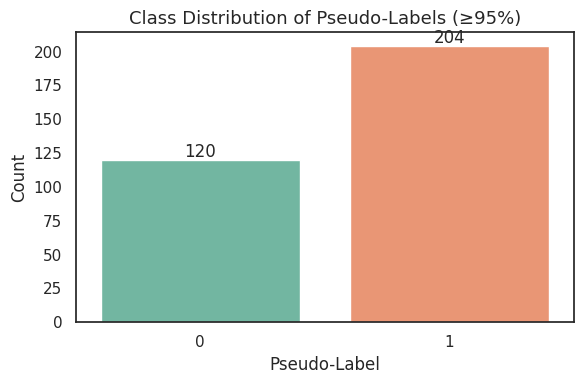

In [123]:
plt.figure(figsize=(6,4))
sns.countplot(x=y_pseudo, palette="Set2")
plt.title("Class Distribution of Pseudo-Labels (≥95%)", fontsize=13)
plt.xlabel("Pseudo-Label")
plt.ylabel("Count")
for i, count in enumerate(np.bincount(y_pseudo)):
    plt.text(i, count + 2, str(count), ha='center', fontsize=12)
plt.tight_layout()
plt.show()


In [136]:
from scipy.sparse import vstack

X_combined = vstack([X_labeled, X_pseudo])
y_combined = np.concatenate([y_labeled, y_pseudo])


In [140]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=500, random_state=42)
X_reduced = svd.fit_transform(X_combined)


In [142]:
X_train, X_val, y_train, y_val = train_test_split(
    X_reduced,
    y_combined,
    test_size=0.2,
    random_state=42,
    stratify=y_combined
)

In [143]:

model2 = XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    colsample_bytree=0.8,
    subsample=0.9,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

model2.fit(X_train, y_train)

from sklearn.metrics import accuracy_score, classification_report

y_val_pred = model2.predict(X_val)
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))


Validation Accuracy: 0.8556701030927835
              precision    recall  f1-score   support

           0       0.81      0.85      0.83        40
           1       0.89      0.86      0.88        57

    accuracy                           0.86        97
   macro avg       0.85      0.85      0.85        97
weighted avg       0.86      0.86      0.86        97



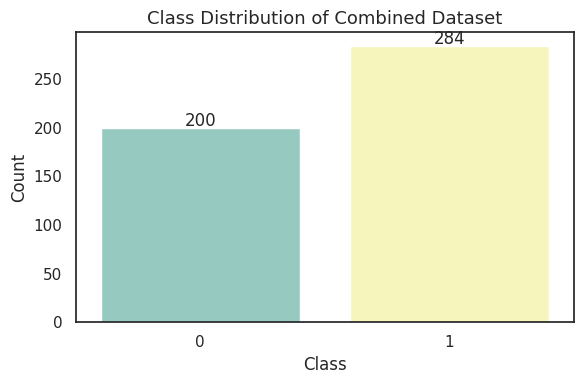

In [144]:
plt.figure(figsize=(6,4))
sns.countplot(x=y_combined, palette="Set3")
plt.title("Class Distribution of Combined Dataset", fontsize=13)
plt.xlabel("Class")
plt.ylabel("Count")

for i, count in enumerate(np.bincount(y_combined)):
    plt.text(i, count + 2, str(count), ha='center', fontsize=12)

plt.tight_layout()
plt.show()
